# Creating the initial conditions

In [1]:
from roms_tools import Grid

We start by creating a grid. Note that it is important to use the same grid throughout all the steps (i.e., creating tidal forcing, atmospheric forcing, initial conditions, etc.) to set up a consistent ROMS simulation. Here, we use the following grid with the default parameters for the vertical coordinate system.

In [2]:
grid = Grid(
    nx=100, ny=100, size_x=1800, size_y=2400, center_lon=-21, center_lat=61, rot=20
)

In [3]:
grid

Grid(nx=100, ny=100, size_x=1800, size_y=2400, center_lon=-21, center_lat=61, rot=20, N=100, theta_s=5.0, theta_b=2.0, hc=300.0, topography_source='ETOPO5', hmin=5.0, straddle=False)

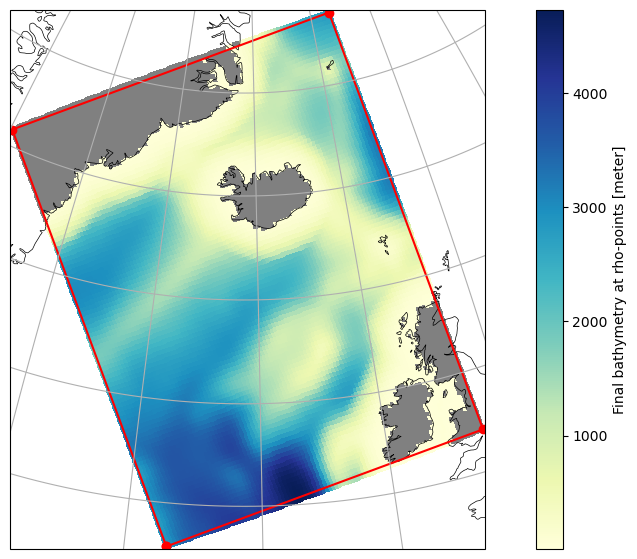

In [4]:
grid.plot(bathymetry=True)

## Physical initial conditions from GLORYS
In this section, we use GLORYS data to create our physical initial conditions, i.e., temperature, salinity, sea surface height, and velocities. (We will learn how to create biogeochemical initial conditions further down in the notebook.) 

Say we want to get initial conditions for January 2, 2012.

In [5]:
from datetime import datetime

ini_time = datetime(2012, 1, 2)

Our GLORYS data for that day sits at the following path.

In [6]:
path = "/glade/derecho/scratch/bachman/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120102.nc"

Note that it would also be okay to provide a filename that contains data for more than just the day of interest. `ROMS-Tools` will pick out the correct day (and complain if the day of interest is not in the provided filename.) Or we can even use wildcards, such as `filename='/glade/derecho/scratch/bachman/GLORYS/NA/2012/*.nc'`.

We can now create the `InitialConditions` object.

In [7]:
from roms_tools import InitialConditions

In [8]:
%%time
initial_conditions = InitialConditions(
    grid=grid,
    ini_time=ini_time,
    physics_source={"name": "GLORYS", "path": path},
    model_reference_date=datetime(
        2000, 1, 1
    ),  # model reference date. Default is January 1, 2000
)

CPU times: user 8.26 s, sys: 153 ms, total: 8.41 s
Wall time: 9.7 s


The initial conditions variables are held in an xarray Dataset that is accessible via the `.ds` property.

In [9]:
initial_conditions.ds

<xarray.Dataset> Size: 21MB
Dimensions:     (ocean_time: 1, eta_rho: 102, xi_rho: 102, s_rho: 100,
                 xi_u: 101, eta_v: 101, s_w: 101)
Coordinates:
    abs_time    (ocean_time) datetime64[ns] 8B 2012-01-02T12:00:00
  * ocean_time  (ocean_time) float64 8B 3.788e+08
Dimensions without coordinates: eta_rho, xi_rho, s_rho, xi_u, eta_v, s_w
Data variables:
    zeta        (ocean_time, eta_rho, xi_rho) float32 42kB -0.4969 ... -0.9301
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 4MB dask.array<chunksize=(1, 100, 102, 101), meta=np.ndarray>
    v           (ocean_time, s_rho, eta_v, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 101, 102), meta=np.ndarray>
    ubar        (ocean_time, eta_rho, xi_u) float32 41kB dask.array<chunksize=(1, 102, 101), meta=np.ndarray>
    vbar        (ocean_time, eta_v, xi_rho) float32 41kB dask.array<chunksize=(1, 101, 102), meta=np.ndarray>
    w           (ocean_time, s_w, eta_rho, xi_rho) float32 4MB 0.0 0.0 ... 0.0
    sc_r        (s_rho) float32 400B -0.995 -0.985 -0.975 ... -0.015 -0.005
    Cs_r        (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
Attributes:
    title:                 ROMS initial conditions file created by ROMS-Tools
    roms_tools_version:    0.1.dev73+dirty
    ini_time:              2012-01-02 00:00:00
    model_reference_date:  2000-01-01 00:00:00
    physical_source:       GLORYS
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0

You can see that all initial conditions variables are Dask arrays, so these fields have not been actually computed yet. An exception is the variable `zeta`, which has been computed to check for NaNs in the interpolated fields, and the variable `w`, which is set to zero. Full computation will not be triggered until the `.plot` or `.save` methods are called.

## Plotting

Let's make some plots! As an example, let's have a look at the temperature field `temp`. It is three-dimensional with horizontal dimensions `eta_rho` and `xi_rho`, and vertical dimension `s_rho`.

In [10]:
initial_conditions.ds.temp

<xarray.DataArray 'temp' (ocean_time: 1, s_rho: 100, eta_rho: 102, xi_rho: 102)> Size: 4MB
dask.array<astype, shape=(1, 100, 102, 102), dtype=float32, chunksize=(1, 100, 102, 102), chunktype=numpy.ndarray>
Coordinates:
    abs_time    (ocean_time) datetime64[ns] 8B 2012-01-02T12:00:00
  * ocean_time  (ocean_time) float64 8B 3.788e+08
Dimensions without coordinates: s_rho, eta_rho, xi_rho
Attributes:
    long_name:  potential temperature
    units:      degrees Celsius

We first want to plot different layers of the temperature field, i.e., slice along the vertical dimension `s`.

In [11]:
from dask.diagnostics import ProgressBar

[########################################] | 100% Completed | 61.16 s
CPU times: user 54 s, sys: 2.93 s, total: 56.9 s
Wall time: 1min 1s


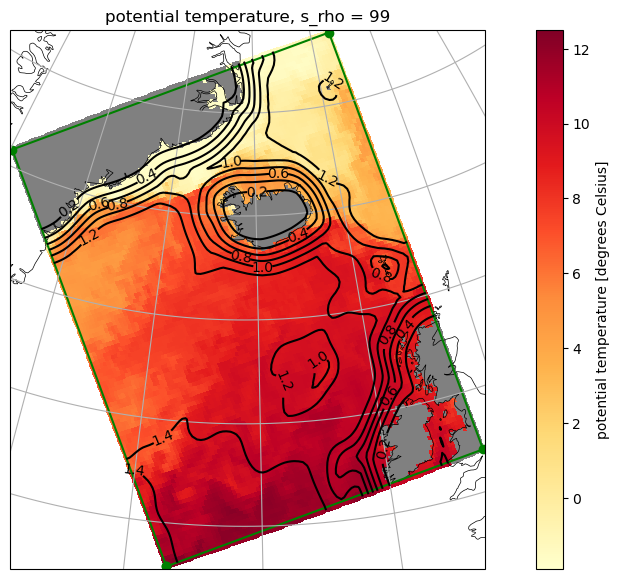

In [12]:
with ProgressBar():
    %time initial_conditions.plot("temp", s=-1, depth_contours=True)  # plot uppermost layer

Note that this took some time because the computation of the three-dimensional temperature field was triggered before plotting. Indeed, the temperature values are now fully computed (and don't need to be re-computed when calling the `.plot` or `.save` methods).

In [13]:
initial_conditions.ds.temp

<xarray.DataArray 'temp' (ocean_time: 1, s_rho: 100, eta_rho: 102, xi_rho: 102)> Size: 4MB
array([[[[ 3.2133336 ,  2.8887794 ,  2.8351593 , ...,  8.045102  ,
           8.14938   ,  8.375315  ],
         [ 2.927417  ,  2.8645372 ,  2.9462984 , ...,  8.169854  ,
           8.211446  ,  8.339263  ],
         [ 3.0651119 ,  3.058829  ,  2.8778355 , ...,  8.214259  ,
           8.221236  ,  8.297204  ],
         ...,
         [-1.197903  , -1.1524245 , -1.1112176 , ..., -0.9849356 ,
          -0.99234957, -0.9892463 ],
         [-1.2427334 , -1.1944467 , -1.1499082 , ..., -0.9963152 ,
          -1.0010488 , -1.0041753 ],
         [-1.2862183 , -1.2359356 , -1.1889087 , ..., -1.006307  ,
          -1.0111945 , -1.0104384 ]],

        [[ 3.2133336 ,  2.9167864 ,  2.8394558 , ...,  8.045077  ,
           8.149358  ,  8.375298  ],
         [ 2.939567  ,  2.884021  ,  2.9462984 , ...,  8.169833  ,
           8.211426  ,  8.339246  ],
         [ 3.0651119 ,  3.058829  ,  2.8778355 , ...,  8.214241  ,
           8.221219  ,  8.297188  ],
...
         [-1.1994343 , -1.1541013 , -1.1130375 , ..., -0.8384761 ,
          -0.5910594 , -0.43460342],
         [-1.2441543 , -1.1960143 , -1.1516196 , ..., -0.5207716 ,
          -0.5480129 , -0.68099326],
         [-1.2875314 , -1.2373962 , -1.190514  , ..., -0.6358841 ,
          -0.6390127 , -0.6442147 ]],

        [[11.861317  , 11.975734  , 12.094538  , ...,  8.042663  ,
           8.147133  ,  8.373431  ],
         [12.045038  , 12.128336  , 12.21467   , ...,  8.167755  ,
           8.209405  ,  8.337438  ],
         [12.213307  , 12.043888  , 11.924701  , ...,  8.21234   ,
           8.21931   ,  8.295416  ],
         ...,
         [-1.199454  , -1.1541224 , -1.1130599 , ..., -0.8383553 ,
          -0.5910602 , -0.43436944],
         [-1.2441735 , -1.1960348 , -1.1516415 , ..., -0.5212487 ,
          -0.54781103, -0.6808458 ],
         [-1.2875499 , -1.2374161 , -1.1905353 , ..., -0.6358841 ,
          -0.6392241 , -0.6443343 ]]]], dtype=float32)
Coordinates:
    abs_time    (ocean_time) datetime64[ns] 8B 2012-01-02T12:00:00
  * ocean_time  (ocean_time) float64 8B 3.788e+08
Dimensions without coordinates: s_rho, eta_rho, xi_rho
Attributes:
    long_name:  potential temperature
    units:      degrees Celsius

Now plotting of the temperature field should be a lot faster.

CPU times: user 130 ms, sys: 707 μs, total: 131 ms
Wall time: 131 ms


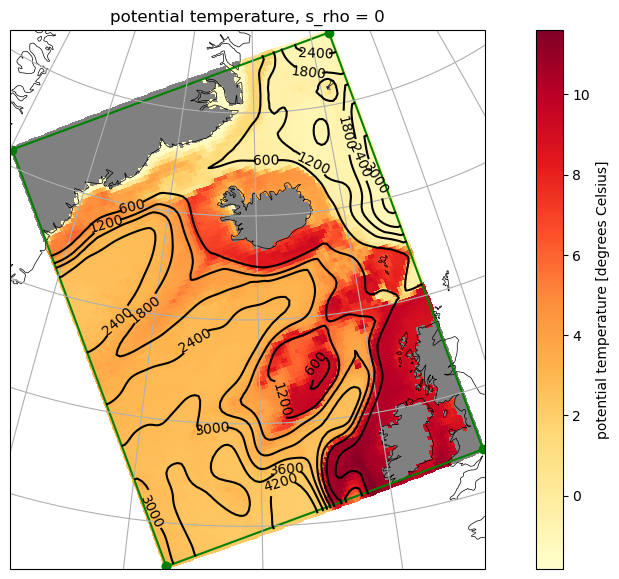

In [14]:
%time initial_conditions.plot("temp", s=0, depth_contours=True)  # plot bottom layer

Next, we slice our domain along one of the horizontal dimensions and look at temperature along these sections.

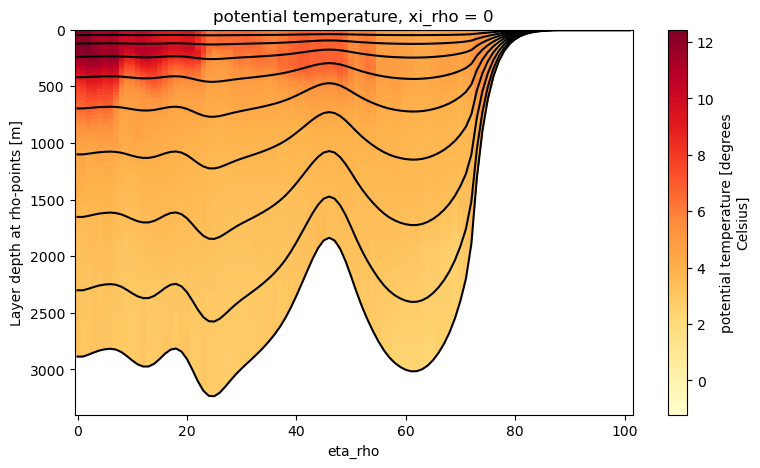

In [15]:
initial_conditions.plot("temp", xi=0, layer_contours=True)

Note that even though we have a total of 100 layers, `layer_contours = True` will create a plot with a maximum of 10 contours to ensure plot clarity.

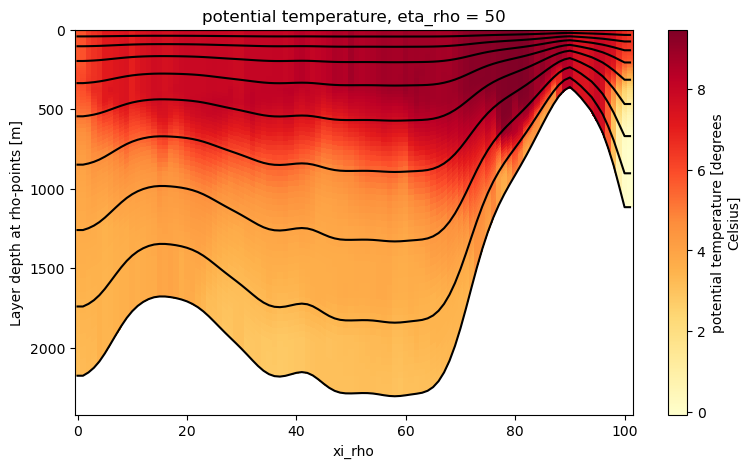

In [16]:
initial_conditions.plot("temp", eta=50, layer_contours=True)

We can also plot a depth profile at at certain spatial location.

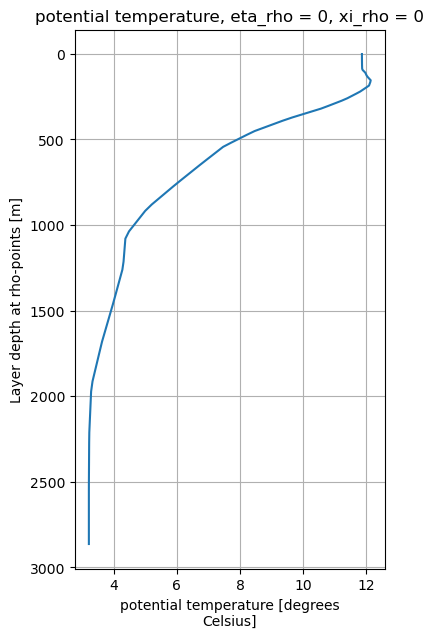

In [17]:
initial_conditions.plot("temp", eta=0, xi=0)

Finally, we can look at a transect in a certain layer and at a fixed `eta_rho` (similarly `xi_rho`).

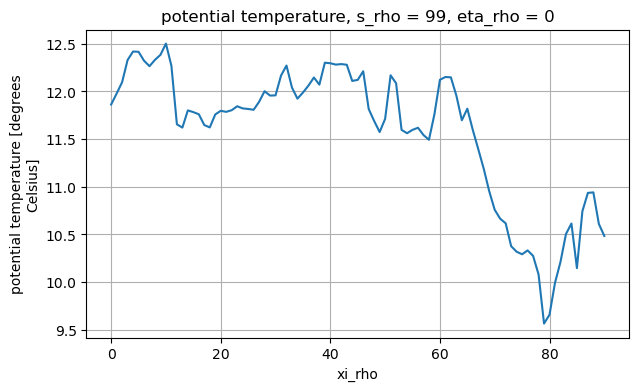

In [18]:
initial_conditions.plot("temp", eta=0, s=-1)

## Adding BGC initial conditions
We now create initial conditions that include both physical variables (again from GLORYS) and biogeochemical (BGC) variables. The BGC variables are taken from a CESM climatology, which is located here.

In [19]:
bgc_path = "/glade/derecho/scratch/noraloose/roms-tools-data/BGC/CESM-climatology_lowres_regridded.nc"

The initial conditions are created as above, but now with additional information about the `bgc_source`.

In [20]:
%%time
initial_conditions_with_bgc = InitialConditions(
    grid=grid,
    ini_time=ini_time,
    physics_source={"name": "GLORYS", "path": path},
    bgc_source={
        "name": "CESM_REGRIDDED",
        "path": bgc_path,
        "climatology": True,
    },
)

CPU times: user 3.06 s, sys: 30.3 ms, total: 3.09 s
Wall time: 3.28 s


In [21]:
initial_conditions_with_bgc.ds

<xarray.Dataset> Size: 154MB
Dimensions:      (ocean_time: 1, eta_rho: 102, xi_rho: 102, s_rho: 100,
                  xi_u: 101, eta_v: 101, s_w: 101)
Coordinates:
    abs_time     (ocean_time) datetime64[ns] 8B 2012-01-02T12:00:00
  * ocean_time   (ocean_time) float64 8B 3.788e+08
Dimensions without coordinates: eta_rho, xi_rho, s_rho, xi_u, eta_v, s_w
Data variables: (12/42)
    zeta         (ocean_time, eta_rho, xi_rho) float32 42kB -0.4969 ... -0.9301
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    u            (ocean_time, s_rho, eta_rho, xi_u) float32 4MB dask.array<chunksize=(1, 100, 102, 101), meta=np.ndarray>
    v            (ocean_time, s_rho, eta_v, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 101, 102), meta=np.ndarray>
    ubar         (ocean_time, eta_rho, xi_u) float32 41kB dask.array<chunksize=(1, 102, 101), meta=np.ndarray>
    ...           ...
    diazFe       (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    spCaCO3      (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    zooC         (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    w            (ocean_time, s_w, eta_rho, xi_rho) float32 4MB 0.0 0.0 ... 0.0
    sc_r         (s_rho) float32 400B -0.995 -0.985 -0.975 ... -0.015 -0.005
    Cs_r         (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
Attributes:
    title:                 ROMS initial conditions file created by ROMS-Tools
    roms_tools_version:    0.1.dev73+dirty
    ini_time:              2012-01-02 00:00:00
    model_reference_date:  2000-01-01 00:00:00
    physical_source:       GLORYS
    bgc_source:            CESM_REGRIDDED
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0

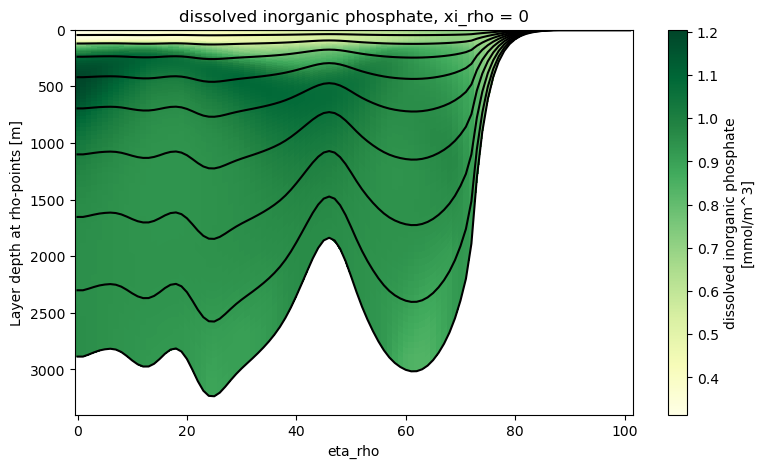

In [22]:
initial_conditions_with_bgc.plot("PO4", xi=0, layer_contours=True)

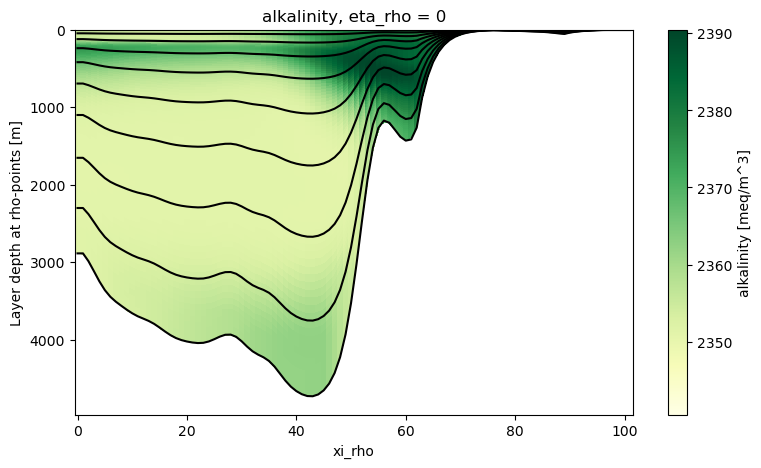

In [23]:
initial_conditions_with_bgc.plot("ALK", eta=0, layer_contours=True)

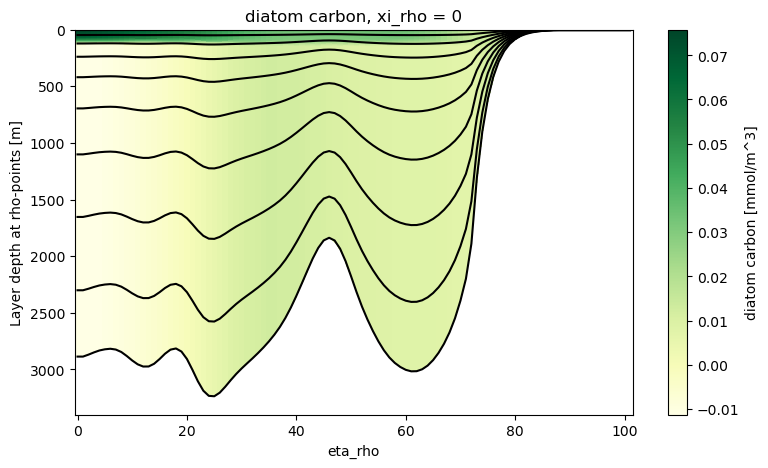

In [24]:
initial_conditions_with_bgc.plot("diatC", xi=0, layer_contours=True)

## Saving as NetCDF or YAML file

We can now save the dataset as a NetCDF file.

In [25]:
filepath = (
    "/glade/derecho/scratch/noraloose/initial_conditions/my_initial_conditions.nc"
)

In [26]:
with ProgressBar():
    %time initial_conditions_with_bgc.save(filepath)

[########################################] | 100% Completed | 198.90 s
CPU times: user 2min 29s, sys: 20.5 s, total: 2min 50s
Wall time: 3min 19s


We can also export the parameters of our `InitialConditions` object to a YAML file.

In [27]:
yaml_filepath = "/glade/derecho/scratch/noraloose/forcing/my_initial_conditions.yaml"

In [28]:
initial_conditions_with_bgc.to_yaml(yaml_filepath)

In [29]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 0.1.dev73+dirty
---
Grid:
  N: 100
  center_lat: 61
  center_lon: -21
  hc: 300.0
  hmin: 5.0
  nx: 100
  ny: 100
  rot: 20
  size_x: 1800
  size_y: 2400
  theta_b: 2.0
  theta_s: 5.0
  topography_source: ETOPO5
InitialConditions:
  bgc_source:
    climatology: true
    name: CESM_REGRIDDED
    path: /glade/derecho/scratch/noraloose/roms-tools-data/BGC/CESM-climatology_lowres_regridded.nc
  ini_time: '2012-01-02T00:00:00'
  model_reference_date: '2000-01-01T00:00:00'
  physics_source:
    climatology: false
    name: GLORYS
    path: /glade/derecho/scratch/bachman/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120102.nc



## Creating initial conditions from an existing YAML file

In [30]:
%time the_same_initial_conditions_with_bgc = InitialConditions.from_yaml(yaml_filepath)

CPU times: user 6.1 s, sys: 2.89 s, total: 8.99 s
Wall time: 9.62 s


In [31]:
the_same_initial_conditions_with_bgc.ds

<xarray.Dataset> Size: 154MB
Dimensions:      (ocean_time: 1, eta_rho: 102, xi_rho: 102, s_rho: 100,
                  xi_u: 101, eta_v: 101, s_w: 101)
Coordinates:
    abs_time     (ocean_time) datetime64[ns] 8B 2012-01-02T12:00:00
  * ocean_time   (ocean_time) float64 8B 3.788e+08
Dimensions without coordinates: eta_rho, xi_rho, s_rho, xi_u, eta_v, s_w
Data variables: (12/42)
    zeta         (ocean_time, eta_rho, xi_rho) float32 42kB -0.4969 ... -0.9301
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    u            (ocean_time, s_rho, eta_rho, xi_u) float32 4MB dask.array<chunksize=(1, 100, 102, 101), meta=np.ndarray>
    v            (ocean_time, s_rho, eta_v, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 101, 102), meta=np.ndarray>
    ubar         (ocean_time, eta_rho, xi_u) float32 41kB dask.array<chunksize=(1, 102, 101), meta=np.ndarray>
    ...           ...
    diazFe       (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    spCaCO3      (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    zooC         (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    w            (ocean_time, s_w, eta_rho, xi_rho) float32 4MB 0.0 0.0 ... 0.0
    sc_r         (s_rho) float32 400B -0.995 -0.985 -0.975 ... -0.015 -0.005
    Cs_r         (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
Attributes:
    title:                 ROMS initial conditions file created by ROMS-Tools
    roms_tools_version:    0.1.dev73+dirty
    ini_time:              2012-01-02 00:00:00
    model_reference_date:  2000-01-01 00:00:00
    physical_source:       GLORYS
    bgc_source:            CESM_REGRIDDED
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0